# Readability Assessment throughConvolutional Neural Network

Readability assessment is a well known problem in natural language processing field. Giving someone the suitable text for his level of comprehension (not so easy and not so hard) could maximize his understanding and enjoyment. In this notebook we are trying to assess the readability of a given text regardless of the text subject using recurrent neural network.

## Corpus
> OneStopEnglish corpus: A new corpus for automatic readability assessment and text simplification  
> Sowmya Vajjala and Ivana Lučić  
> 2018  
> Proceedings of the Thirteenth Workshop on Innovative Use of NLP for Building Educational Applications, pages 297–304. Association for Computational Linguistics.  
> [url](http://aclweb.org/anthology/W18-0535). [bib file](https://aclanthology.coli.uni-saarland.de/papers/W18-0535/w18-0535.bib)

Please cite the above paper if you use this corpus in your research.

[![DOI](https://zenodo.org/badge/128919409.svg)](https://zenodo.org/badge/latestdoi/128919409)

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

Now let's dive into our corpus.

In [22]:
import sys
sys.path.append("/home/ms10596/PycharmProjects/match")
from ipywidgets import interact
from tabulate import tabulate
from IPython.display import display, HTML

from utils.loading import load_glove_embeddings
from utils.one_stop_english import load_corpus, corpus_to_words, corpus_to_pos, detokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional,Conv1D,MaxPooling1D,GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

corpus = load_corpus()
articles_words, tags = corpus_to_words(corpus)
articles_pos, tags = corpus_to_pos(corpus)

Reading level|Avg. Num. Words|Std. Dev|Number of Articles
---|---|---|---
Elementary|533.17|103.79|189
Intermediate|676.59|117.15|189
Advanced|820.49|162.52|189



In [23]:
@interact
def show_articles(i=(0,188,1), words=(0,1000,1)):
    data = [
        ["Advanced",detokenize(articles_words[i][:words])], 
        ["Intermediate",detokenize(articles_words[i+2][:words])], 
        ["Elementary",detokenize(articles_words[i+1][:words])]
    ]
    headers = ['Reading Level', 'Example']
    display(HTML(tabulate(data,tablefmt='html', headers=headers)+"<style>th,td {font-size: 10px}</style>"))

interactive(children=(IntSlider(value=94, description='i', max=188), IntSlider(value=500, description='words',…

In [24]:
print(articles_words[0][:10])
print(articles_pos[0][:10])

['When', 'you', 'see', 'the', 'word', 'Amazon', ',', 'whats', 'the', 'first']
['WRB', 'PRP', 'VB', 'DT', 'NN', 'NN', ',', 'VBZ', 'DT', 'JJ']


In [25]:
maxlen = 1000 # Cuts off reviews after 1000 words
max_words = 45
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(articles_pos)
print(tokenizer.word_index)

{'nn': 1, 'in': 2, 'dt': 3, 'jj': 4, 'nns': 5, 'nnp': 6, ',': 7, '.': 8, 'rb': 9, 'prp': 10, 'vb': 11, 'vbd': 12, 'cc': 13, 'vbz': 14, 'to': 15, 'vbp': 16, 'cd': 17, 'vbn': 18, 'vbg': 19, 'prp$': 20, 'md': 21, 'wdt': 22, 'wrb': 23, 'wp': 24, 'jjr': 25, 'rp': 26, ':': 27, 'jjs': 28, 'ex': 29, 'rbr': 30, 'nnps': 31, '-rrb-': 32, '-lrb-': 33, 'rbs': 34, 'pdt': 35, '$': 36, 'fw': 37, 'uh': 38, 'wp$': 39, 'sym': 40, "''": 41, 'ls': 42, 'pos': 43, '``': 44}


In [26]:
sequences = tokenizer.texts_to_sequences(articles_pos)
print(np.shape(sequences))
print(sequences[0][:10])

(567,)
[23, 10, 11, 3, 1, 1, 7, 14, 3, 4]


In [27]:
data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
print(data[0])
print(np.shape(data))

[23 10 11  3  1  1  7 14  3  4  1 22 14 15 11  3  4 28  1  7  3 28  1 13
  3 28  1  1 13 22 16 10 16 34  4  8  3  5 16 18 15  3  1  2  3  4  7 13
  9  4  7  1  2 23 15 11  3  5  2  3  1  8  6 13  6 16 18  5 15  3  1 18
  2  3  6  4  1  2  3  4  4  1  2  1 27  8 11  8  3  4  1 14 18  2 20  1
 15 11  3  4  1  1 19  9  8  4 32  7 13  3  6  6  5 16  3 21 11  3  1  2
  3  1  1  2  4  1  7  3  1  2  4  5 13  4  4  1 14  8  9  2  5  2  4  4
  5 15  5  7 19  8  6  6  8  4  7  3  1 14 15  3  1  2  5  2  3  1 13  1
  2  3  1  8  2  9  7  3  5  2  4  7  4 13  4  5  2  1 12  9  4  2  3  1
  1  2  8  1 14  8  1 13 17  4  5  8 13  3  5 13  4  4  5 33  5 32  2 10
 16  9 18 16  2 15 11  3 28  1  2  3  1  2  3  4  1  8  3  6  6  2  6 31
 13 31 33  6 32  3  4  4  1 22 14  3  4  1  2  1  1 14 18  5 33  3  9  4
  9 36 17 32  2  5  2  4  5 15 11 15  3  4 17  8  6 14 18  2  5  2  4  5
  7 19  8  1 14  8  1 14  8  1 11  8 11  8 13 20 34  4  1 14  2 20  4  1
  8  6 13  6 16 18  2  3  8  1  1 15 11 18  7 19  3

In [28]:
print(tags[0])
tags = to_categorical(tags)
print(tags[0])
print(np.shape(tags))

2
[0. 0. 1.]
(567, 3)


In [36]:
data = to_categorical(data)
print(data.shape)
print(data[0])

(567, 1000, 45)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [38]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
tags = tags[indices]

In [53]:
model = Sequential()
model.add(Conv1D(128, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(MaxPooling1D(5))
model.add(Conv1D(64, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.0, l2=0.0)))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 5, activation='relu',kernel_regularizer=l1_l2(l1=0, l2=0.0)))
model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='softmax'))
# model.summary()

In [54]:
es = EarlyStopping(monitor='val_acc',patience=100, mode='auto')
model.compile(optimizer=RMSprop(),
loss='categorical_crossentropy',
metrics=['acc'])
history = model.fit(data, tags,
epochs=1000,  
batch_size=50,
validation_split=0.2,
callbacks=[es])
# model.save_weights('pre_trained_glove_model.h5')
model.summary()

Train on 453 samples, validate on 114 samples
Epoch 1/1000
453/453 [==============================] - 1s 2ms/step - loss: 2.2042 - acc: 0.3135 - val_loss: 2.0097 - val_acc: 0.3333
Epoch 2/1000
453/453 [==============================] - 0s 647us/step - loss: 1.9180 - acc: 0.3046 - val_loss: 1.7919 - val_acc: 0.3333
Epoch 3/1000
453/453 [==============================] - 0s 655us/step - loss: 1.7175 - acc: 0.3355 - val_loss: 1.6234 - val_acc: 0.3333
Epoch 4/1000
453/453 [==============================] - 0s 640us/step - loss: 1.5618 - acc: 0.3377 - val_loss: 1.4829 - val_acc: 0.3860
Epoch 5/1000
453/453 [==============================] - 0s 646us/step - loss: 1.4283 - acc: 0.4018 - val_loss: 1.3791 - val_acc: 0.3333
Epoch 6/1000
453/453 [==============================] - 0s 639us/step - loss: 1.3325 - acc: 0.3135 - val_loss: 1.2971 - val_acc: 0.2807
Epoch 7/1000
453/453 [==============================] - 0s 639us/step - loss: 1.2599 - acc: 0.3642 - val_loss: 1.2387 - val_acc: 0.3333
Epoc

453/453 [==============================] - 0s 625us/step - loss: 0.5793 - acc: 0.9051 - val_loss: 1.5171 - val_acc: 0.3772
Epoch 61/1000
453/453 [==============================] - 0s 626us/step - loss: 0.5599 - acc: 0.9448 - val_loss: 1.4619 - val_acc: 0.3947
Epoch 62/1000
453/453 [==============================] - 0s 627us/step - loss: 0.5473 - acc: 0.9227 - val_loss: 1.3584 - val_acc: 0.3947
Epoch 63/1000
453/453 [==============================] - 0s 628us/step - loss: 0.5069 - acc: 0.9558 - val_loss: 1.8628 - val_acc: 0.3421
Epoch 64/1000
453/453 [==============================] - 0s 627us/step - loss: 0.5120 - acc: 0.9382 - val_loss: 1.6262 - val_acc: 0.3421
Epoch 65/1000
453/453 [==============================] - 0s 627us/step - loss: 0.4749 - acc: 0.9647 - val_loss: 1.7485 - val_acc: 0.3333
Epoch 66/1000
453/453 [==============================] - 0s 630us/step - loss: 0.4576 - acc: 0.9603 - val_loss: 1.5021 - val_acc: 0.3860
Epoch 67/1000
453/453 [==============================] 

Epoch 120/1000
453/453 [==============================] - 0s 626us/step - loss: 0.0933 - acc: 1.0000 - val_loss: 1.8552 - val_acc: 0.3860
Epoch 121/1000
453/453 [==============================] - 0s 627us/step - loss: 0.0987 - acc: 1.0000 - val_loss: 1.5721 - val_acc: 0.3947
Epoch 122/1000
453/453 [==============================] - 0s 629us/step - loss: 0.0912 - acc: 1.0000 - val_loss: 2.7382 - val_acc: 0.3596
Epoch 123/1000
453/453 [==============================] - 0s 622us/step - loss: 0.1406 - acc: 0.9890 - val_loss: 1.6022 - val_acc: 0.4386
Epoch 124/1000
453/453 [==============================] - 0s 624us/step - loss: 0.0881 - acc: 1.0000 - val_loss: 1.7648 - val_acc: 0.4123
Epoch 125/1000
453/453 [==============================] - 0s 630us/step - loss: 0.0869 - acc: 1.0000 - val_loss: 1.6477 - val_acc: 0.4123
Epoch 126/1000
453/453 [==============================] - 0s 628us/step - loss: 0.0895 - acc: 1.0000 - val_loss: 2.6949 - val_acc: 0.3333
Epoch 127/1000
453/453 [==========

453/453 [==============================] - 0s 638us/step - loss: 0.0510 - acc: 1.0000 - val_loss: 1.8360 - val_acc: 0.3772
Epoch 180/1000
453/453 [==============================] - 0s 627us/step - loss: 0.0832 - acc: 1.0000 - val_loss: 1.6951 - val_acc: 0.3947
Epoch 181/1000
453/453 [==============================] - 0s 625us/step - loss: 0.0509 - acc: 1.0000 - val_loss: 1.5954 - val_acc: 0.4298
Epoch 182/1000
453/453 [==============================] - 0s 624us/step - loss: 0.0492 - acc: 1.0000 - val_loss: 1.7254 - val_acc: 0.3860
Epoch 183/1000
453/453 [==============================] - 0s 630us/step - loss: 0.0526 - acc: 1.0000 - val_loss: 1.7227 - val_acc: 0.3772
Epoch 184/1000
453/453 [==============================] - 0s 631us/step - loss: 0.0490 - acc: 1.0000 - val_loss: 1.7489 - val_acc: 0.4035
Epoch 185/1000
453/453 [==============================] - 0s 630us/step - loss: 0.0737 - acc: 1.0000 - val_loss: 1.7642 - val_acc: 0.3596
Epoch 186/1000
453/453 [=========================

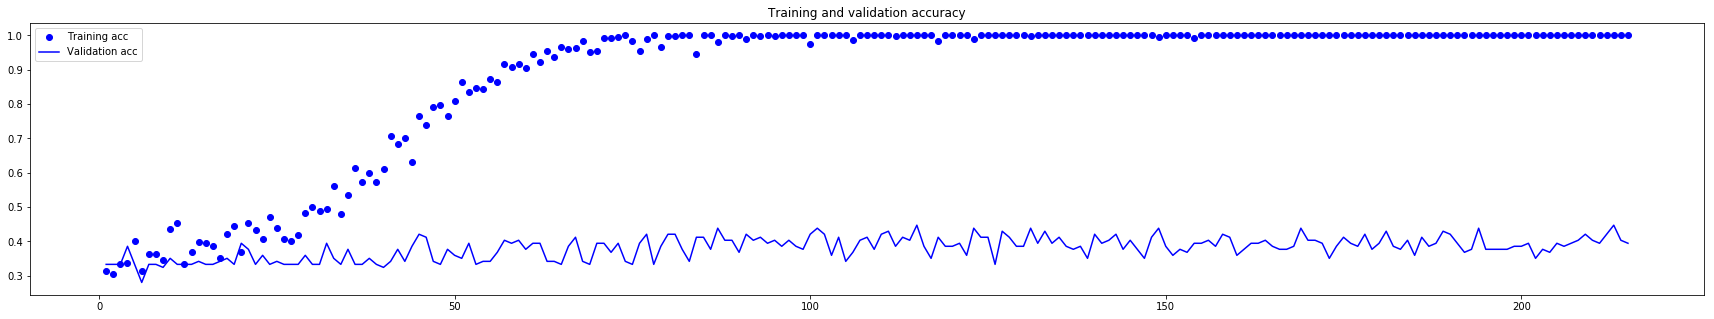

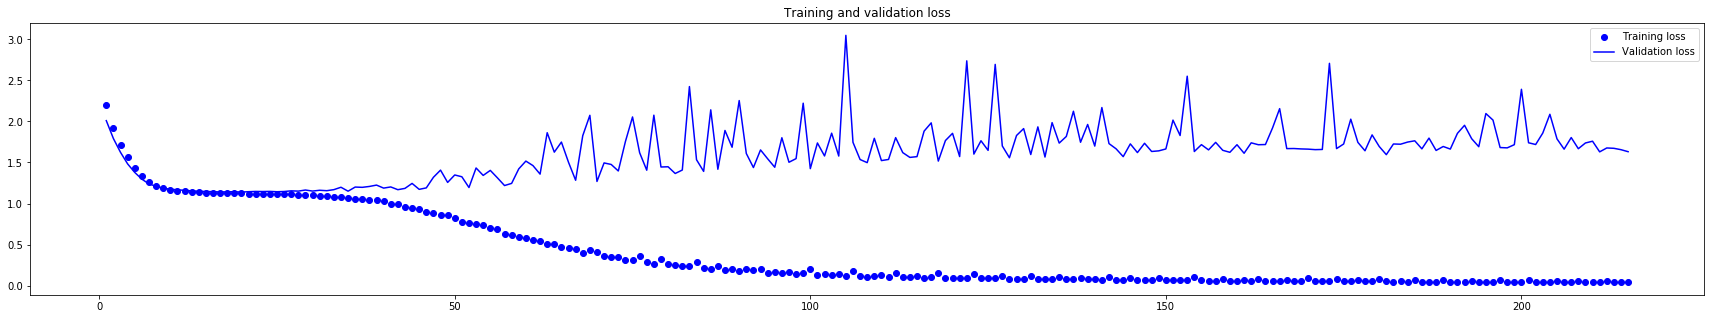

In [55]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(30,5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure(figsize=(30,5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()




In [92]:
result = model.evaluate(data, labels)
print(result[1])

567/567 [==============================] - 0s 599us/step
0.539682539472294
